# Incorporating Human Feedback into Quality Diversity for Diversified Text-to-Image Generation

by [Li Ding](https://liding.info), author of [Quality Diversity through Human Feedback (QDHF)](https://liding.info/qdhf/), edited and reviewed by [Bryon Tjanaka](https://btjanaka.net/)

*This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read.*

Foundation models such as large language models (LLMs) and text-to-image generation models ([Stable Diffusion](https://arxiv.org/abs/2112.10752), [DALL·E](https://openai.com/dall-e-3), etc.) in effect compress vast archives of human knowledge into powerful and flexible tools, serving as a foundation for down-stream applications. One mechanism to build upon such foundational knowledge is reinforcement learning from human feedback (RLHF), which can make models both easier to use (by aligning them to human instructions), and more competent (by improving their capabilities based on human preferences).

RLHF is a relatively new paradigm, and its deployments often follow the relatively narrow recipe of maximizing a learned reward model of averaged human preferences over model responses. However, there are drawbacks when it is used to optimize for average human preferences, especially in generative tasks that demand diverse and creative model responses. On the other hand, Quality Diversity (QD) algorithms excel at identifying diverse and high-quality solutions but often rely on manually-crafted diversity metrics, as shown in previous examples, such as [DQD](https://docs.pyribs.org/en/latest/tutorials/tom_cruise_dqd.html).

In this work, we introduce [Quality Diversity through Human Feedback (QDHF)](https://liding.info/qdhf/), which aims to broaden the RLHF recipe to include optimizing for interesting diversity among responses, which is of practical importance for many creative applications such as text-to-image generation. Such increased diversity can also improve optimization for complex and open-ended tasks (through improved exploration), personalization (serving individual rather than average human preference), and fairness (to offset algorithmic biases in gender, ethnicity, and more).

<br>

![Overview of QDHF.](_static/qdhf-method.png)

<br>

Our main idea is to derive distinct representations of what humans find interestingly different, and use such diversity representations to support optimization. An overview of our method is shown in the diagram above.

In this tutorial, we implement QDHF for the latent space illumination (LSI) experiment. LSI uses QD algorithms to search for a diverse collection of images in a GAN’s latent space, which has been introduced in the previous [DQD tutorial](https://docs.pyribs.org/en/latest/tutorials/tom_cruise_dqd.html). However, instead of generating images of a celebrity, this LSI pipeline uses [Stable Diffusion](https://arxiv.org/abs/2112.10752) to generate diverse images according to a given text prompt, like the one shown below (*prompt: an image of a bear in a national park*).

![QDHF example](_static/qdhf-example.jpg)

Another difference in this tutorial is that, QDHF uses human feedback to derive meaningful diversity metrics, not by manually specifying attributes such as age and hair length. We use a preference model, [DreamSim](https://dreamsim-nights.github.io/), which is trained on a dataset of human judgment of similarity between images, to source feedback in QDHF optimization. Specifically, we implement QDHF with Map-Elites, and run it with the Stable Diffusion+CLIP pipeline.

*This tutorial assumes that you are familiar with Latent Space Illumination (LSI). If you are not yet familiar with it, we recommend reviewing the [DQD tutorial](https://docs.pyribs.org/en/latest/tutorials/tom_cruise_dqd.html) which generates Tom Cruise Images or the [LSI MNIST tutorial](https://docs.pyribs.org/en/latest/tutorials/lsi_mnist.html) which generates diverse MNIST digits.*

## Setup

Since Stable Diffusion, CLIP, and DreamSim are fairly large models, you will need a GPU to run this tutorial. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

Below, we check what GPU has been provided. The possible GPUs (at the time of writing) are as follows; factory reset the runtime if you do not have a desired GPU.

* V100 = Excellent (*Available only for Colab Pro users*)
* P100 = Very Good
* T4 = Good (*preferred*)
* K80 = Meh
* P4 = (*Not Recommended*)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-70c83cee-934f-c99a-60ae-5866505757af)


Now, we install various libraries, including pyribs, CLIP, Stable Diffusion, and DreamSim. This cell will take around 5-10 minutes to run since it involves downloading multiple large files.

In [ ]:
%pip install ribs[visualize] torch torchvision git+https://github.com/openai/CLIP tqdm dreamsim diffusers accelerate

In [3]:
import time
import numpy as np
from tqdm import tqdm, trange

Let's first set up CUDA for PyTorch. We use float16 to save GPU memories for large models.

In [4]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print("Torch device:", DEVICE)

# Use float16 for GPU, float32 for CPU.
TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32
print("Torch dtype:", TORCH_DTYPE)

Torch device: cuda
Torch dtype: torch.float16


## Preliminaries: CLIP, Stable Diffusion, and DreamSim

Below we set up CLIP, Stable Diffusion, and DreamSim. The code for these models is adopted from the [DQD tutorial](https://docs.pyribs.org/en/latest/tutorials/tom_cruise_dqd.html), the [DreamSim demo](https://colab.research.google.com/drive/1taEOMzFE9g81D9AwH27Uhy2U82tQGAVI?usp=sharing), and the [Hugging Face Stable Diffusion example](https://huggingface.co/stabilityai/stable-diffusion-2-1). Each cell may take around 3 minutes to run since it involves downloading multiple large files.

*Since this section is focused on the LSI pipeline rather than on pyribs, feel free to skim past and come back to it later.*

### CLIP for Connecting Text and Images

In [5]:
import clip

# This tutorial uses ViT-B/32, you may use other checkpoints depending on your resources and need.
CLIP_MODEL, CLIP_PREPROCESS = clip.load("ViT-B/32", device=DEVICE)
CLIP_MODEL.eval()
for p in CLIP_MODEL.parameters():
    p.requires_grad_(False)


def compute_clip_scores(imgs, text, return_clip_features=False):
    """Computes CLIP scores for a batch of images and a given text prompt."""
    img_tensor = torch.stack([CLIP_PREPROCESS(img) for img in imgs]).to(DEVICE)
    tokenized_text = clip.tokenize([text]).to(DEVICE)
    img_logits, _text_logits = CLIP_MODEL(img_tensor, tokenized_text)
    img_logits = img_logits.detach().cpu().numpy().astype(np.float32)[:, 0]
    img_logits = 1 / img_logits * 100
    # Remap the objective from minimizing [0, 10] to maximizing [0, 100]
    img_logits = (10.0 - img_logits) * 10.0

    if return_clip_features:
        clip_features = CLIP_MODEL.encode_image(img_tensor).to(TORCH_DTYPE)
        return img_logits, clip_features
    else:
        return img_logits

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]


### DreamSim for Simulating Human Feedback

In [6]:
from dreamsim import dreamsim

DREAMSIM_MODEL, DREAMSIM_PREPROCESS = dreamsim(
    pretrained=True, dreamsim_type="open_clip_vitb32", device=DEVICE
)

100%|██████████| 313M/313M [00:19<00:00, 16.5MB/s]


Unzipping...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:143: UserWarning: fan_in_fan_out is set to True but the target module is not a Conv1D. Setting fan_in_fan_out to False.
  warnings.warn(


### Stable Diffusion for Generating Images
By default, we use the [`miniSD-diffusers` checkpoint](https://huggingface.co/lambdalabs/miniSD-diffusers), which generates images at 256x256 for faster inference and less GPU memory usage. Please switch to the `stable-diffusion-2-1-base` checkpoint to generate images with higher resolution and quality.

In [7]:
from diffusers import StableDiffusionPipeline

IMG_WIDTH = 256
IMG_HEIGHT = 256
SD_IN_HEIGHT = 32
SD_IN_WIDTH = 32
SD_CHECKPOINT = "lambdalabs/miniSD-diffusers"

# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# SD_IN_HEIGHT = 64
# SD_IN_WIDTH = 64
# SD_CHECKPOINT = "stabilityai/stable-diffusion-2-1-base"

BATCH_SIZE = 4
SD_IN_CHANNELS = 4
SD_IN_SHAPE = (
    BATCH_SIZE,
    SD_IN_CHANNELS,
    SD_IN_HEIGHT,
    SD_IN_WIDTH,
)

SDPIPE = StableDiffusionPipeline.from_pretrained(
    SD_CHECKPOINT,
    torch_dtype=TORCH_DTYPE,
    safety_checker=None,  # For faster inference.
    requires_safety_checker=False,
)

SDPIPE.set_progress_bar_config(disable=True)
SDPIPE = SDPIPE.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settin

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Aligning Diversity Metrics with Human Preferences

Next, we define a latent projection model to characterize diversity from image features through constrastive learning from human feedback.
The `DivProj` model projects the image features (e.g., CLIP features with 512-d) onto a low-dimensional latent space (e.g., 2-d), where each dimension represents a numeric diversity metric.
An intuitive example is that the model may learn "object size" as a metric, where low values mean the object is small and high values mean it is large.

In [8]:
from torch import nn


class DivProj(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=latent_dim),
        )

    def forward(self, x):
        """Get diversity representations."""
        x = self.proj(x)
        return x

    def calc_dis(self, x1, x2):
        """Calculate diversity distance as (squared) L2 distance."""
        x1 = self.forward(x1)
        x2 = self.forward(x2)
        return torch.sum(torch.square(x1 - x2), -1)

    def triplet_delta_dis(self, ref, x1, x2):
        """Calculate delta distance comparing x1 and x2 to ref."""
        x1 = self.forward(x1)
        x2 = self.forward(x2)
        ref = self.forward(ref)
        return (torch.sum(torch.square(ref - x1), -1) -
                torch.sum(torch.square(ref - x2), -1))

### Constrastive Learning for Diversity Projection

For contrastive learning, we use a triplet loss to train the diversity projection model. This loss encourages the model to project similar images close to each other in the latent space, and dissimilar images far from each other. The preference labels are given by the DreamSim model, which is pre-trained on the human feedback on image similarity, so we will use it as the source of feedback here.

To avoid redundancy in computation, we first extract DreamSim features from the images, and then calculate the cosine similarity of DreamSim features. This is equivalent to using the DreamSim model directly to calculate the similarity.

The whole `fit_div_proj` process works as follows: The input data is with shape of `(n, 3, image_size, image_size)`, where n is the number of triplets. The second dimension of 3 represents the reference, positive, and negative images. We split the data into traning and validation sets, and then train the diversity projection model with the triplet loss. The output is a diversity projection model that projects image features onto a low-dimensional latent space, where each dimension represents a numeric diversity metric.

In [9]:
# Triplet loss with margin 0.05.
# The binary preference labels are scaled to y = 1 or -1 for the loss, where y = 1 means x2 is more similar to ref than x1.
loss_fn = lambda y, delta_dis: torch.max(
    torch.tensor([0.0]).to(DEVICE), 0.05 - (y * 2 - 1) * delta_dis
).mean()


def fit_div_proj(inputs, dreamsim_features, latent_dim, batch_size=32):
    """Trains the DivProj model on ground-truth labels."""
    t = time.time()
    model = DivProj(input_dim=inputs.shape[-1], latent_dim=latent_dim)
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    n_pref_data = inputs.shape[0]
    ref = inputs[:, 0]
    x1 = inputs[:, 1]
    x2 = inputs[:, 2]

    n_train = int(n_pref_data * 0.75)
    n_val = n_pref_data - n_train

    # Split data into train and val.
    ref_train = ref[:n_train]
    x1_train = x1[:n_train]
    x2_train = x2[:n_train]
    ref_val = ref[n_train:]
    x1_val = x1[n_train:]
    x2_val = x2[n_train:]

    # Split DreamSim features into train and val.
    ref_dreamsim_features = dreamsim_features[:, 0]
    x1_dreamsim_features = dreamsim_features[:, 1]
    x2_dreamsim_features = dreamsim_features[:, 2]
    ref_gt_train = ref_dreamsim_features[:n_train]
    x1_gt_train = x1_dreamsim_features[:n_train]
    x2_gt_train = x2_dreamsim_features[:n_train]
    ref_gt_val = ref_dreamsim_features[n_train:]
    x1_gt_val = x1_dreamsim_features[n_train:]
    x2_gt_val = x2_dreamsim_features[n_train:]

    val_acc = []
    n_iters_per_epoch = max((n_train) // batch_size, 1)
    for epoch in range(200):
        for _ in range(n_iters_per_epoch):
            optimizer.zero_grad()

            idx = np.random.choice(n_train, batch_size)
            batch_ref = ref_train[idx].float()
            batch1 = x1_train[idx].float()
            batch2 = x2_train[idx].float()

            # Get delta distance from model.
            delta_dis = model.triplet_delta_dis(batch_ref, batch1, batch2)

            # Get preference labels from DreamSim features.
            gt_dis = torch.nn.functional.cosine_similarity(
                ref_gt_train[idx], x2_gt_train[idx], dim=-1
            ) - torch.nn.functional.cosine_similarity(
                ref_gt_train[idx], x1_gt_train[idx], dim=-1
            )
            gt = (gt_dis > 0).to(TORCH_DTYPE)

            loss = loss_fn(gt, delta_dis)
            loss.backward()
            optimizer.step()

        # Validate.
        n_correct = 0
        n_total = 0
        with torch.no_grad():
            idx = np.arange(n_val)
            batch_ref = ref_val[idx].float()
            batch1 = x1_val[idx].float()
            batch2 = x2_val[idx].float()
            delta_dis = model.triplet_delta_dis(batch_ref, batch1, batch2)
            pred = delta_dis > 0
            gt_dis = torch.nn.functional.cosine_similarity(
                ref_gt_val[idx], x2_gt_val[idx], dim=-1
            ) - torch.nn.functional.cosine_similarity(
                ref_gt_val[idx], x1_gt_val[idx], dim=-1
            )
            gt = gt_dis > 0
            n_correct += (pred == gt).sum().item()
            n_total += len(idx)

        acc = n_correct / n_total
        val_acc.append(acc)

        # Early stopping if val_acc does not improve for 10 epochs.
        if epoch > 10 and np.mean(val_acc[-10:]) < np.mean(val_acc[-11:-1]):
            break

    print(
        f"{np.round(time.time()- t, 1)}s ({epoch+1} epochs) | DivProj (n={n_pref_data}) fitted with val acc.: {acc}"
    )

    return model.to(TORCH_DTYPE), acc

### Helper Functions to Compute Objectives and Measures

In [10]:
def compute_diversity_measures(clip_features, diversity_model):
    with torch.no_grad():
        measures = diversity_model(clip_features).detach().cpu().numpy()
    return measures


def evaluate_lsi(
    latents,
    prompt,
    return_features=False,
    diversity_model=None,
):
    """Evaluates the objective of LSI for a batch of latents and a given text prompt."""

    images = SDPIPE(
        prompt,
        num_images_per_prompt=latents.shape[0],
        latents=latents,
        # num_inference_steps=1,  # For testing.
    ).images

    objs, clip_features = compute_clip_scores(
        images,
        prompt,
        return_clip_features=True,
    )

    images = torch.cat([DREAMSIM_PREPROCESS(img) for img in images]).to(DEVICE)
    dreamsim_features = DREAMSIM_MODEL.embed(images)

    if diversity_model is not None:
        measures = compute_diversity_measures(clip_features, diversity_model)
    else:
        measures = None

    if return_features:
        return objs, measures, clip_features, dreamsim_features
    else:
        return objs, measures

## QDHF with pyribs

To use QDHF to generate diverse collections of images, we will use the MAP-Elites algorithm, where the diversity metrics are progressively trained and fine-tuned during optimization.

### Algorithm Setup

To set up the MAP-Elites instance for QDHF, we will set up the following components. First, we create the [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html). The archive is 20x20 and stores Stable Diffusion latent vectors. The dimensions of vectors are (BATCH, 4, H, W) where H=W=32 if generating 256x256 images with `miniSD`, or 64 for 512x512 images with `stable-diffusion-2-1-base`. Next, we create a [`GaussianEmitter`](https://docs.pyribs.org/en/latest/api/ribs.emitters.GaussianEmitter.html) that generates solutions by mutating existing archive solutions with Gaussian noise. Finally, we set up a [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html) to combine everything together.

In [11]:
from ribs.archives import GridArchive
from ribs.schedulers import Scheduler
from ribs.emitters import GaussianEmitter

GRID_SIZE = (20, 20)
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

def tensor_to_list(tensor):
    sols = tensor.detach().cpu().numpy().astype(np.float32)
    return sols.reshape(sols.shape[0], -1)


def list_to_tensor(list_):
    sols = np.array(list_).reshape(
        len(list_), 4, SD_IN_HEIGHT, SD_IN_WIDTH
    )  # Hard-coded for now.
    return torch.tensor(sols, dtype=TORCH_DTYPE, device=DEVICE)


def create_scheduler(
    sols,
    objs,
    clip_features,
    diversity_model,
    seed=None,
):
    measures = compute_diversity_measures(clip_features, diversity_model)
    archive_bounds = np.array(
        [np.quantile(measures, 0.01, axis=0), np.quantile(measures, 0.99, axis=0)]
    ).T

    sols = tensor_to_list(sols)

    # Set up archive.
    archive = GridArchive(
        solution_dim=len(sols[0]), dims=GRID_SIZE, ranges=archive_bounds, seed=SEED
    )

    # Add initial solutions to the archive.
    archive.add(sols, objs, measures)

    # Set up the GaussianEmitter.
    emitters = [
        GaussianEmitter(
            archive=archive,
            sigma=0.1,
            initial_solutions=archive.sample_elites(BATCH_SIZE)["solution"],
            batch_size=BATCH_SIZE,
            seed=SEED,
        )
    ]

    # Return the archive and scheduler.
    return archive, Scheduler(archive, emitters)

## LSI with QDHF

Having set up the necessary components above, we now run QDHF to search for images of a given prompt. The default prompt is "an astronaut riding a horse on mars".

### Training

The execution loop is similar to the experiments in previous tutorials. The main difference is that when the iteration is in `update_schedule`, we will update the QD archive by fine-tuning the diversity metrics and adding current solutions to the archive again with regard to their updated diversity measures.

The total number of iterations is set to be 200, and it should take ~45min to run on a GPU.

In [12]:
# Change here for whatever you would like to generate.
prompt = "an astronaut riding a horse on mars"

INIT_POP = 200  # Initial population.

TOTAL_ITRS = 200  # Total number of iterations.
update_schedule = [1, 21, 51, 101]  # Iterations on which to update the archive.
n_pref_data = 1000  # Number of preferences used in each update.

archive = None
best = 0.0
for itr in trange(1, TOTAL_ITRS + 1):
    itr_start = time.time()

    # Update archive and scheduler if needed.
    if itr in update_schedule:
        if archive is None:
            tqdm.write("Initializing archive and diversity projection.")

            all_sols = []
            all_clip_features = []
            all_dreamsim_features = []
            all_objs = []

            # Sample random solutions and get judgment on similarity.
            n_batches = INIT_POP // BATCH_SIZE
            for _ in range(n_batches):
                sols = torch.randn(SD_IN_SHAPE, device=DEVICE, dtype=TORCH_DTYPE)
                objs, _, clip_features, dreamsim_features = evaluate_lsi(
                    sols, prompt, return_features=True
                )
                all_sols.append(sols)
                all_clip_features.append(clip_features)
                all_dreamsim_features.append(dreamsim_features)
                all_objs.append(objs)
            all_sols = torch.concat(all_sols, dim=0)
            all_clip_features = torch.concat(all_clip_features, dim=0)
            all_dreamsim_features = torch.concat(all_dreamsim_features, dim=0)
            all_objs = np.concatenate(all_objs, axis=0)

            # Initialize the diversity projection model.
            div_proj_data = []
            div_proj_labels = []
            for _ in range(n_pref_data):
                idx = np.random.choice(all_sols.shape[0], 3)
                div_proj_data.append(all_clip_features[idx])
                div_proj_labels.append(all_dreamsim_features[idx])
            div_proj_data = torch.concat(div_proj_data, dim=0)
            div_proj_labels = torch.concat(div_proj_labels, dim=0)
            div_proj_data = div_proj_data.reshape(n_pref_data, 3, -1)
            div_proj_label = div_proj_labels.reshape(n_pref_data, 3, -1)
            diversity_model, div_proj_acc = fit_div_proj(
                div_proj_data,
                div_proj_label,
                latent_dim=2,
            )

        else:
            tqdm.write("Updating archive and diversity projection.")

            # Get all the current solutions and collect feedback.
            all_sols = list_to_tensor(archive.data("solution"))
            n_batches = np.ceil(len(all_sols) / BATCH_SIZE).astype(int)
            all_clip_features = []
            all_dreamsim_features = []
            all_objs = []
            for i in range(n_batches):
                sols = all_sols[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
                objs, _, clip_features, dreamsim_features = evaluate_lsi(
                    sols, prompt, return_features=True
                )
                all_clip_features.append(clip_features)
                all_dreamsim_features.append(dreamsim_features)
                all_objs.append(objs)
            all_clip_features = torch.concat(
                all_clip_features, dim=0
            )  # n_pref_data * 3, dim
            all_dreamsim_features = torch.concat(all_dreamsim_features, dim=0)
            all_objs = np.concatenate(all_objs, axis=0)

            # Update the diversity projection model.
            additional_features = []
            additional_labels = []
            for _ in range(n_pref_data):
                idx = np.random.choice(all_sols.shape[0], 3)
                additional_features.append(all_clip_features[idx])
                additional_labels.append(all_dreamsim_features[idx])
            additional_features = torch.concat(additional_features, dim=0)
            additional_labels = torch.concat(additional_labels, dim=0)
            additional_div_proj_data = additional_features.reshape(n_pref_data, 3, -1)
            additional_div_proj_label = additional_labels.reshape(n_pref_data, 3, -1)
            div_proj_data = torch.concat(
                (div_proj_data, additional_div_proj_data), axis=0
            )
            div_proj_label = torch.concat(
                (div_proj_label, additional_div_proj_label), axis=0
            )
            diversity_model, div_proj_acc = fit_div_proj(
                div_proj_data,
                div_proj_label,
                latent_dim=2,
            )

        archive, scheduler = create_scheduler(
            all_sols,
            all_objs,
            all_clip_features,
            diversity_model,
            seed=SEED,
        )

    # Primary QD loop.
    sols = scheduler.ask()
    sols = list_to_tensor(sols)
    objs, measures, clip_features, dreamsim_features = evaluate_lsi(
        sols, prompt, return_features=True, diversity_model=diversity_model
    )
    best = max(best, max(objs))
    scheduler.tell(objs, measures)

    # This can be used as a flag to save on the final iteration, but note that
    # we do not save results in this tutorial.
    final_itr = itr == TOTAL_ITRS

    # Update the summary statistics for the archive.
    qd_score, coverage = archive.stats.norm_qd_score, archive.stats.coverage

    tqdm.write(f"QD score: {np.round(qd_score, 2)} Coverage: {coverage * 100}")

  0%|          | 0/200 [00:00<?, ?it/s]

Initializing archive and diversity projection.
1.5s (21 epochs) | DivProj (n=1000) fitted with val acc.: 0.764


  0%|          | 1/200 [05:56<19:43:49, 356.93s/it]

QD score: 24.97 Coverage: 34.5


  1%|          | 2/200 [06:03<8:18:25, 151.04s/it] 

QD score: 25.15 Coverage: 34.75


  2%|▏         | 3/200 [06:10<4:39:50, 85.23s/it] 

QD score: 25.52 Coverage: 35.25


  2%|▏         | 4/200 [06:17<2:57:26, 54.32s/it]

QD score: 26.06 Coverage: 36.0


  2%|▎         | 5/200 [06:24<2:00:59, 37.23s/it]

QD score: 26.06 Coverage: 36.0


  3%|▎         | 6/200 [06:31<1:27:03, 26.92s/it]

QD score: 26.42 Coverage: 36.5


  4%|▎         | 7/200 [06:38<1:05:36, 20.39s/it]

QD score: 26.78 Coverage: 37.0


  4%|▍         | 8/200 [06:45<51:34, 16.12s/it]  

QD score: 27.15 Coverage: 37.5


  4%|▍         | 9/200 [06:52<42:07, 13.24s/it]

QD score: 27.69 Coverage: 38.25


  5%|▌         | 10/200 [06:59<35:42, 11.28s/it]

QD score: 27.87 Coverage: 38.5


  6%|▌         | 11/200 [07:06<31:16,  9.93s/it]

QD score: 28.23 Coverage: 39.0


  6%|▌         | 12/200 [07:13<28:12,  9.00s/it]

QD score: 28.41 Coverage: 39.25


  6%|▋         | 13/200 [07:19<26:04,  8.36s/it]

QD score: 28.6 Coverage: 39.5


  7%|▋         | 14/200 [07:26<24:34,  7.93s/it]

QD score: 28.96 Coverage: 40.0


  8%|▊         | 15/200 [07:33<23:29,  7.62s/it]

QD score: 28.97 Coverage: 40.0


  8%|▊         | 16/200 [07:40<22:41,  7.40s/it]

QD score: 29.51 Coverage: 40.75


  8%|▊         | 17/200 [07:47<22:04,  7.24s/it]

QD score: 29.69 Coverage: 41.0


  9%|▉         | 18/200 [07:54<21:38,  7.14s/it]

QD score: 30.06 Coverage: 41.5


 10%|▉         | 19/200 [08:01<21:18,  7.06s/it]

QD score: 30.25 Coverage: 41.75


 10%|█         | 20/200 [08:08<21:01,  7.01s/it]

QD score: 30.43 Coverage: 42.0
Updating archive and diversity projection.
1.5s (13 epochs) | DivProj (n=2000) fitted with val acc.: 0.752


 10%|█         | 21/200 [13:05<4:41:01, 94.20s/it]

QD score: 23.55 Coverage: 32.5


 11%|█         | 22/200 [13:12<3:21:43, 68.00s/it]

QD score: 23.73 Coverage: 32.75


 12%|█▏        | 23/200 [13:19<2:26:29, 49.66s/it]

QD score: 24.09 Coverage: 33.25


 12%|█▏        | 24/200 [13:26<1:48:02, 36.83s/it]

QD score: 24.45 Coverage: 33.75


 12%|█▎        | 25/200 [13:33<1:21:14, 27.86s/it]

QD score: 24.82 Coverage: 34.25


 13%|█▎        | 26/200 [13:40<1:02:33, 21.57s/it]

QD score: 25.19 Coverage: 34.75


 14%|█▎        | 27/200 [13:47<49:30, 17.17s/it]  

QD score: 25.37 Coverage: 35.0


 14%|█▍        | 28/200 [13:53<40:24, 14.10s/it]

QD score: 25.55 Coverage: 35.25


 14%|█▍        | 29/200 [14:00<34:01, 11.94s/it]

QD score: 25.92 Coverage: 35.75


 15%|█▌        | 30/200 [14:07<29:33, 10.43s/it]

QD score: 26.48 Coverage: 36.5


 16%|█▌        | 31/200 [14:14<26:25,  9.38s/it]

QD score: 26.99 Coverage: 37.25


 16%|█▌        | 32/200 [14:21<24:11,  8.64s/it]

QD score: 27.34 Coverage: 37.75


 16%|█▋        | 33/200 [14:28<22:36,  8.12s/it]

QD score: 28.04 Coverage: 38.75


 17%|█▋        | 34/200 [14:35<21:27,  7.75s/it]

QD score: 28.57 Coverage: 39.5


 18%|█▊        | 35/200 [14:42<20:38,  7.50s/it]

QD score: 28.95 Coverage: 40.0


 18%|█▊        | 36/200 [14:49<20:01,  7.33s/it]

QD score: 29.13 Coverage: 40.25


 18%|█▊        | 37/200 [14:56<19:33,  7.20s/it]

QD score: 29.87 Coverage: 41.25


 19%|█▉        | 38/200 [15:03<19:13,  7.12s/it]

QD score: 30.23 Coverage: 41.75


 20%|█▉        | 39/200 [15:10<18:56,  7.06s/it]

QD score: 30.42 Coverage: 42.0


 20%|██        | 40/200 [15:16<18:42,  7.01s/it]

QD score: 30.77 Coverage: 42.5


 20%|██        | 41/200 [15:23<18:29,  6.98s/it]

QD score: 30.96 Coverage: 42.75


 21%|██        | 42/200 [15:30<18:18,  6.95s/it]

QD score: 31.33 Coverage: 43.25


 22%|██▏       | 43/200 [15:37<18:09,  6.94s/it]

QD score: 31.5 Coverage: 43.5


 22%|██▏       | 44/200 [15:44<18:02,  6.94s/it]

QD score: 31.68 Coverage: 43.75


 22%|██▎       | 45/200 [15:51<17:53,  6.92s/it]

QD score: 32.21 Coverage: 44.5


 23%|██▎       | 46/200 [15:58<17:44,  6.91s/it]

QD score: 32.74 Coverage: 45.25


 24%|██▎       | 47/200 [16:05<17:37,  6.91s/it]

QD score: 32.75 Coverage: 45.25


 24%|██▍       | 48/200 [16:12<17:29,  6.91s/it]

QD score: 33.29 Coverage: 46.0


 24%|██▍       | 49/200 [16:19<17:22,  6.91s/it]

QD score: 33.81 Coverage: 46.75


 25%|██▌       | 50/200 [16:25<17:16,  6.91s/it]

QD score: 34.55 Coverage: 47.75
Updating archive and diversity projection.
2.3s (14 epochs) | DivProj (n=3000) fitted with val acc.: 0.76


 26%|██▌       | 51/200 [22:04<4:24:18, 106.43s/it]

QD score: 25.7 Coverage: 35.5


 26%|██▌       | 52/200 [22:11<3:08:52, 76.57s/it] 

QD score: 26.05 Coverage: 36.0


 26%|██▋       | 53/200 [22:18<2:16:22, 55.67s/it]

QD score: 26.41 Coverage: 36.5


 27%|██▋       | 54/200 [22:25<1:39:53, 41.05s/it]

QD score: 26.59 Coverage: 36.75


 28%|██▊       | 55/200 [22:32<1:14:26, 30.80s/it]

QD score: 27.14 Coverage: 37.5


 28%|██▊       | 56/200 [22:39<56:43, 23.63s/it]  

QD score: 27.68 Coverage: 38.25


 28%|██▊       | 57/200 [22:46<44:21, 18.61s/it]

QD score: 27.86 Coverage: 38.5


 29%|██▉       | 58/200 [22:52<35:43, 15.09s/it]

QD score: 28.41 Coverage: 39.25


 30%|██▉       | 59/200 [22:59<29:41, 12.63s/it]

QD score: 28.97 Coverage: 40.0


 30%|███       | 60/200 [23:06<25:27, 10.91s/it]

QD score: 29.34 Coverage: 40.5


 30%|███       | 61/200 [23:13<22:28,  9.70s/it]

QD score: 29.87 Coverage: 41.25


 31%|███       | 62/200 [23:20<20:22,  8.86s/it]

QD score: 30.59 Coverage: 42.25


 32%|███▏      | 63/200 [23:27<18:52,  8.26s/it]

QD score: 30.95 Coverage: 42.75


 32%|███▏      | 64/200 [23:34<17:47,  7.85s/it]

QD score: 31.31 Coverage: 43.25


 32%|███▎      | 65/200 [23:41<17:00,  7.56s/it]

QD score: 31.5 Coverage: 43.5


 33%|███▎      | 66/200 [23:48<16:25,  7.36s/it]

QD score: 32.06 Coverage: 44.25


 34%|███▎      | 67/200 [23:54<16:00,  7.22s/it]

QD score: 32.6 Coverage: 45.0


 34%|███▍      | 68/200 [24:01<15:41,  7.13s/it]

QD score: 32.6 Coverage: 45.0


 34%|███▍      | 69/200 [24:08<15:26,  7.07s/it]

QD score: 32.95 Coverage: 45.5


 35%|███▌      | 70/200 [24:15<15:13,  7.02s/it]

QD score: 32.95 Coverage: 45.5


 36%|███▌      | 71/200 [24:22<15:01,  6.99s/it]

QD score: 33.33 Coverage: 46.0


 36%|███▌      | 72/200 [24:29<14:51,  6.97s/it]

QD score: 33.52 Coverage: 46.25


 36%|███▋      | 73/200 [24:36<14:42,  6.95s/it]

QD score: 33.88 Coverage: 46.75


 37%|███▋      | 74/200 [24:43<14:33,  6.94s/it]

QD score: 34.41 Coverage: 47.5


 38%|███▊      | 75/200 [24:50<14:26,  6.94s/it]

QD score: 34.58 Coverage: 47.75


 38%|███▊      | 76/200 [24:57<14:18,  6.92s/it]

QD score: 34.58 Coverage: 47.75


 38%|███▊      | 77/200 [25:04<14:10,  6.92s/it]

QD score: 34.77 Coverage: 48.0


 39%|███▉      | 78/200 [25:10<14:02,  6.91s/it]

QD score: 34.77 Coverage: 48.0


 40%|███▉      | 79/200 [25:17<13:55,  6.90s/it]

QD score: 34.96 Coverage: 48.25


 40%|████      | 80/200 [25:24<13:49,  6.91s/it]

QD score: 34.96 Coverage: 48.25


 40%|████      | 81/200 [25:31<13:41,  6.91s/it]

QD score: 34.96 Coverage: 48.25


 41%|████      | 82/200 [25:38<13:35,  6.91s/it]

QD score: 35.33 Coverage: 48.75


 42%|████▏     | 83/200 [25:45<13:29,  6.92s/it]

QD score: 35.34 Coverage: 48.75


 42%|████▏     | 84/200 [25:52<13:22,  6.92s/it]

QD score: 35.52 Coverage: 49.0


 42%|████▎     | 85/200 [25:59<13:14,  6.91s/it]

QD score: 35.53 Coverage: 49.0


 43%|████▎     | 86/200 [26:06<13:07,  6.91s/it]

QD score: 35.7 Coverage: 49.25


 44%|████▎     | 87/200 [26:13<13:01,  6.91s/it]

QD score: 36.06 Coverage: 49.75


 44%|████▍     | 88/200 [26:20<12:53,  6.91s/it]

QD score: 36.42 Coverage: 50.24999999999999


 44%|████▍     | 89/200 [26:26<12:46,  6.91s/it]

QD score: 36.78 Coverage: 50.74999999999999


 45%|████▌     | 90/200 [26:33<12:39,  6.90s/it]

QD score: 37.13 Coverage: 51.24999999999999


 46%|████▌     | 91/200 [26:40<12:32,  6.90s/it]

QD score: 37.67 Coverage: 52.0


 46%|████▌     | 92/200 [26:47<12:25,  6.90s/it]

QD score: 38.03 Coverage: 52.5


 46%|████▋     | 93/200 [26:54<12:18,  6.91s/it]

QD score: 38.2 Coverage: 52.75


 47%|████▋     | 94/200 [27:01<12:12,  6.91s/it]

QD score: 38.39 Coverage: 53.0


 48%|████▊     | 95/200 [27:08<12:05,  6.91s/it]

QD score: 38.39 Coverage: 53.0


 48%|████▊     | 96/200 [27:15<11:58,  6.91s/it]

QD score: 38.39 Coverage: 53.0


 48%|████▊     | 97/200 [27:22<11:51,  6.91s/it]

QD score: 38.92 Coverage: 53.75


 49%|████▉     | 98/200 [27:29<11:44,  6.90s/it]

QD score: 38.92 Coverage: 53.75


 50%|████▉     | 99/200 [27:35<11:36,  6.90s/it]

QD score: 39.29 Coverage: 54.25


 50%|█████     | 100/200 [27:42<11:29,  6.90s/it]

QD score: 39.46 Coverage: 54.50000000000001
Updating archive and diversity projection.
3.0s (12 epochs) | DivProj (n=4000) fitted with val acc.: 0.751


 50%|█████     | 101/200 [34:09<3:19:07, 120.68s/it]

QD score: 28.94 Coverage: 40.0


 51%|█████     | 102/200 [34:15<2:21:21, 86.54s/it] 

QD score: 28.95 Coverage: 40.0


 52%|█████▏    | 103/200 [34:22<1:41:16, 62.65s/it]

QD score: 29.13 Coverage: 40.25


 52%|█████▏    | 104/200 [34:29<1:13:29, 45.93s/it]

QD score: 29.13 Coverage: 40.25


 52%|█████▎    | 105/200 [34:36<54:11, 34.23s/it]  

QD score: 29.32 Coverage: 40.5


 53%|█████▎    | 106/200 [34:43<40:46, 26.03s/it]

QD score: 29.68 Coverage: 41.0


 54%|█████▎    | 107/200 [34:50<31:26, 20.29s/it]

QD score: 30.22 Coverage: 41.75


 54%|█████▍    | 108/200 [34:57<24:56, 16.27s/it]

QD score: 30.41 Coverage: 42.0


 55%|█████▍    | 109/200 [35:04<20:24, 13.46s/it]

QD score: 30.76 Coverage: 42.5


 55%|█████▌    | 110/200 [35:11<17:13, 11.48s/it]

QD score: 31.31 Coverage: 43.25


 56%|█████▌    | 111/200 [35:18<14:59, 10.11s/it]

QD score: 31.48 Coverage: 43.5


 56%|█████▌    | 112/200 [35:24<13:25,  9.15s/it]

QD score: 31.84 Coverage: 44.0


 56%|█████▋    | 113/200 [35:31<12:17,  8.48s/it]

QD score: 32.02 Coverage: 44.25


 57%|█████▋    | 114/200 [35:38<11:28,  8.00s/it]

QD score: 32.19 Coverage: 44.5


 57%|█████▊    | 115/200 [35:45<10:52,  7.67s/it]

QD score: 32.56 Coverage: 45.0


 58%|█████▊    | 116/200 [35:52<10:24,  7.44s/it]

QD score: 32.93 Coverage: 45.5


 58%|█████▊    | 117/200 [35:59<10:04,  7.28s/it]

QD score: 33.29 Coverage: 46.0


 59%|█████▉    | 118/200 [36:06<09:48,  7.17s/it]

QD score: 33.47 Coverage: 46.25


 60%|█████▉    | 119/200 [36:13<09:35,  7.11s/it]

QD score: 33.82 Coverage: 46.75


 60%|██████    | 120/200 [36:20<09:24,  7.05s/it]

QD score: 34.37 Coverage: 47.5


 60%|██████    | 121/200 [36:27<09:13,  7.01s/it]

QD score: 34.56 Coverage: 47.75


 61%|██████    | 122/200 [36:34<09:04,  6.98s/it]

QD score: 34.74 Coverage: 48.0


 62%|██████▏   | 123/200 [36:40<08:55,  6.96s/it]

QD score: 34.92 Coverage: 48.25


 62%|██████▏   | 124/200 [36:47<08:48,  6.95s/it]

QD score: 34.92 Coverage: 48.25


 62%|██████▎   | 125/200 [36:54<08:40,  6.94s/it]

QD score: 35.11 Coverage: 48.5


 63%|██████▎   | 126/200 [37:01<08:32,  6.93s/it]

QD score: 35.48 Coverage: 49.0


 64%|██████▎   | 127/200 [37:08<08:25,  6.92s/it]

QD score: 35.84 Coverage: 49.5


 64%|██████▍   | 128/200 [37:15<08:17,  6.91s/it]

QD score: 35.85 Coverage: 49.5


 64%|██████▍   | 129/200 [37:22<08:18,  7.02s/it]

QD score: 35.86 Coverage: 49.5


 65%|██████▌   | 130/200 [37:29<08:15,  7.07s/it]

QD score: 36.23 Coverage: 50.0


 66%|██████▌   | 131/200 [37:37<08:13,  7.15s/it]

QD score: 36.42 Coverage: 50.24999999999999


 66%|██████▌   | 132/200 [37:44<08:01,  7.08s/it]

QD score: 36.78 Coverage: 50.74999999999999


 66%|██████▋   | 133/200 [37:51<07:51,  7.03s/it]

QD score: 36.97 Coverage: 51.0


 67%|██████▋   | 134/200 [37:58<07:41,  6.99s/it]

QD score: 37.16 Coverage: 51.24999999999999


 68%|██████▊   | 135/200 [38:04<07:32,  6.96s/it]

QD score: 37.52 Coverage: 51.74999999999999


 68%|██████▊   | 136/200 [38:11<07:25,  6.95s/it]

QD score: 37.71 Coverage: 52.0


 68%|██████▊   | 137/200 [38:18<07:17,  6.94s/it]

QD score: 37.72 Coverage: 52.0


 69%|██████▉   | 138/200 [38:25<07:09,  6.93s/it]

QD score: 37.9 Coverage: 52.25


 70%|██████▉   | 139/200 [38:32<07:02,  6.92s/it]

QD score: 37.91 Coverage: 52.25


 70%|███████   | 140/200 [38:39<06:54,  6.92s/it]

QD score: 37.91 Coverage: 52.25


 70%|███████   | 141/200 [38:46<06:47,  6.91s/it]

QD score: 38.45 Coverage: 53.0


 71%|███████   | 142/200 [38:53<06:41,  6.91s/it]

QD score: 38.45 Coverage: 53.0


 72%|███████▏  | 143/200 [39:00<06:34,  6.92s/it]

QD score: 38.99 Coverage: 53.75


 72%|███████▏  | 144/200 [39:07<06:26,  6.91s/it]

QD score: 38.99 Coverage: 53.75


 72%|███████▎  | 145/200 [39:14<06:19,  6.90s/it]

QD score: 39.17 Coverage: 54.0


 73%|███████▎  | 146/200 [39:20<06:12,  6.90s/it]

QD score: 39.19 Coverage: 54.0


 74%|███████▎  | 147/200 [39:27<06:05,  6.90s/it]

QD score: 39.19 Coverage: 54.0


 74%|███████▍  | 148/200 [39:34<05:58,  6.90s/it]

QD score: 39.19 Coverage: 54.0


 74%|███████▍  | 149/200 [39:41<05:51,  6.90s/it]

QD score: 39.37 Coverage: 54.25


 75%|███████▌  | 150/200 [39:48<05:45,  6.91s/it]

QD score: 39.55 Coverage: 54.50000000000001


 76%|███████▌  | 151/200 [39:55<05:38,  6.90s/it]

QD score: 39.55 Coverage: 54.50000000000001


 76%|███████▌  | 152/200 [40:02<05:31,  6.90s/it]

QD score: 39.74 Coverage: 54.75


 76%|███████▋  | 153/200 [40:09<05:24,  6.90s/it]

QD score: 40.1 Coverage: 55.25


 77%|███████▋  | 154/200 [40:16<05:17,  6.91s/it]

QD score: 40.11 Coverage: 55.25


 78%|███████▊  | 155/200 [40:23<05:10,  6.91s/it]

QD score: 40.29 Coverage: 55.50000000000001


 78%|███████▊  | 156/200 [40:29<05:03,  6.90s/it]

QD score: 40.3 Coverage: 55.50000000000001


 78%|███████▊  | 157/200 [40:36<04:57,  6.91s/it]

QD score: 40.3 Coverage: 55.50000000000001


 79%|███████▉  | 158/200 [40:43<04:50,  6.92s/it]

QD score: 40.49 Coverage: 55.75


 80%|███████▉  | 159/200 [40:50<04:43,  6.91s/it]

QD score: 40.49 Coverage: 55.75


 80%|████████  | 160/200 [40:57<04:36,  6.91s/it]

QD score: 40.5 Coverage: 55.75


 80%|████████  | 161/200 [41:04<04:29,  6.91s/it]

QD score: 40.5 Coverage: 55.75


 81%|████████  | 162/200 [41:11<04:23,  6.92s/it]

QD score: 40.51 Coverage: 55.75


 82%|████████▏ | 163/200 [41:18<04:16,  6.92s/it]

QD score: 40.69 Coverage: 56.00000000000001


 82%|████████▏ | 164/200 [41:25<04:09,  6.92s/it]

QD score: 40.69 Coverage: 56.00000000000001


 82%|████████▎ | 165/200 [41:32<04:01,  6.91s/it]

QD score: 41.04 Coverage: 56.49999999999999


 83%|████████▎ | 166/200 [41:39<03:55,  6.92s/it]

QD score: 41.05 Coverage: 56.49999999999999


 84%|████████▎ | 167/200 [41:46<03:48,  6.91s/it]

QD score: 41.05 Coverage: 56.49999999999999


 84%|████████▍ | 168/200 [41:52<03:40,  6.90s/it]

QD score: 41.05 Coverage: 56.49999999999999


 84%|████████▍ | 169/200 [41:59<03:34,  6.91s/it]

QD score: 41.05 Coverage: 56.49999999999999


 85%|████████▌ | 170/200 [42:06<03:27,  6.91s/it]

QD score: 41.24 Coverage: 56.75


 86%|████████▌ | 171/200 [42:13<03:20,  6.91s/it]

QD score: 41.42 Coverage: 56.99999999999999


 86%|████████▌ | 172/200 [42:20<03:13,  6.90s/it]

QD score: 41.42 Coverage: 56.99999999999999


 86%|████████▋ | 173/200 [42:27<03:06,  6.90s/it]

QD score: 41.61 Coverage: 57.25


 87%|████████▋ | 174/200 [42:34<02:59,  6.91s/it]

QD score: 41.8 Coverage: 57.49999999999999


 88%|████████▊ | 175/200 [42:41<02:52,  6.91s/it]

QD score: 41.8 Coverage: 57.49999999999999


 88%|████████▊ | 176/200 [42:48<02:45,  6.91s/it]

QD score: 41.8 Coverage: 57.49999999999999


 88%|████████▊ | 177/200 [42:55<02:38,  6.91s/it]

QD score: 41.8 Coverage: 57.49999999999999


 89%|████████▉ | 178/200 [43:01<02:31,  6.91s/it]

QD score: 41.98 Coverage: 57.75


 90%|████████▉ | 179/200 [43:08<02:24,  6.90s/it]

QD score: 42.51 Coverage: 58.5


 90%|█████████ | 180/200 [43:15<02:18,  6.90s/it]

QD score: 42.88 Coverage: 59.0


 90%|█████████ | 181/200 [43:22<02:11,  6.90s/it]

QD score: 43.06 Coverage: 59.25


 91%|█████████ | 182/200 [43:29<02:04,  6.90s/it]

QD score: 43.23 Coverage: 59.5


 92%|█████████▏| 183/200 [43:36<01:57,  6.91s/it]

QD score: 43.4 Coverage: 59.75


 92%|█████████▏| 184/200 [43:43<01:50,  6.91s/it]

QD score: 43.41 Coverage: 59.75


 92%|█████████▎| 185/200 [43:50<01:43,  6.91s/it]

QD score: 43.76 Coverage: 60.25


 93%|█████████▎| 186/200 [43:57<01:36,  6.91s/it]

QD score: 43.93 Coverage: 60.5


 94%|█████████▎| 187/200 [44:04<01:29,  6.92s/it]

QD score: 43.93 Coverage: 60.5


 94%|█████████▍| 188/200 [44:11<01:22,  6.91s/it]

QD score: 43.93 Coverage: 60.5


 94%|█████████▍| 189/200 [44:17<01:16,  6.91s/it]

QD score: 43.94 Coverage: 60.5


 95%|█████████▌| 190/200 [44:24<01:09,  6.92s/it]

QD score: 44.3 Coverage: 61.0


 96%|█████████▌| 191/200 [44:31<01:02,  6.92s/it]

QD score: 44.3 Coverage: 61.0


 96%|█████████▌| 192/200 [44:38<00:55,  6.91s/it]

QD score: 44.31 Coverage: 61.0


 96%|█████████▋| 193/200 [44:45<00:48,  6.91s/it]

QD score: 44.31 Coverage: 61.0


 97%|█████████▋| 194/200 [44:52<00:41,  6.91s/it]

QD score: 44.67 Coverage: 61.5


 98%|█████████▊| 195/200 [44:59<00:34,  6.92s/it]

QD score: 44.67 Coverage: 61.5


 98%|█████████▊| 196/200 [45:06<00:27,  6.92s/it]

QD score: 44.85 Coverage: 61.75000000000001


 98%|█████████▊| 197/200 [45:13<00:20,  6.92s/it]

QD score: 44.85 Coverage: 61.75000000000001


 99%|█████████▉| 198/200 [45:20<00:13,  6.92s/it]

QD score: 44.85 Coverage: 61.75000000000001


100%|█████████▉| 199/200 [45:27<00:06,  6.92s/it]

QD score: 45.05 Coverage: 62.0


100%|██████████| 200/200 [45:34<00:00, 13.67s/it]

QD score: 45.05 Coverage: 62.0


## Visualization
### Visualizing the Archive
We use the `grid_archive_heatmap` function to visualize the grid archive as a heatmap.

Text(0, 0.5, 'Diversity Metric 2')

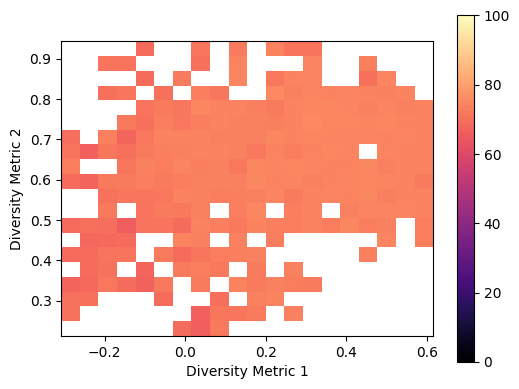

In [13]:
from matplotlib import pyplot as plt
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(6, 4.5))
grid_archive_heatmap(archive, aspect="equal", vmin=0, vmax=100)
plt.xlabel("Diversity Metric 1")
plt.ylabel("Diversity Metric 2")

We can see that the archive is filled with diverse images, and the diversity metrics are well distributed.

### Visualizing the Results

Now let's view the images from across the archive generated by QDHF. We randomly sample images in the grid with measures spread across the diversity dimensions.

In [14]:
import itertools

# Modify this to determine how many images to plot along each dimension.
img_freq = (
    4,  # Number of columns of images.
    4,  # Number of rows of images.
)

# List of images.
imgs = []

# Convert archive to a df with solutions available.
df = archive.data(return_type="pandas")

# Compute the min and max measures for which solutions were found.
measure_bounds = np.array(
    [
        (df["measures_0"].min(), df["measures_0"].max()),
        (df["measures_1"].min(), df["measures_1"].max()),
    ]
)

archive_bounds = np.array(
    [archive.boundaries[0][[0, -1]], archive.boundaries[1][[0, -1]]]
)


delta_measures_0 = (archive_bounds[0][1] - archive_bounds[0][0]) / img_freq[0]
delta_measures_1 = (archive_bounds[1][1] - archive_bounds[1][0]) / img_freq[1]


for col, row in itertools.product(range(img_freq[1]), range(img_freq[0])):
    # Compute bounds of a box in measure space.
    measures_0_low = archive_bounds[0][0] + delta_measures_0 * row
    measures_0_high = archive_bounds[0][0] + delta_measures_0 * (row + 1)
    measures_1_low = archive_bounds[1][0] + delta_measures_1 * col
    measures_1_high = archive_bounds[1][0] + delta_measures_1 * (col + 1)

    if row == 0:
        measures_0_low = measure_bounds[0][0]
    if col == 0:
        measures_1_low = measure_bounds[1][0]
    if row == img_freq[0] - 1:
        measures_0_high = measure_bounds[0][1]
    if col == img_freq[1] - 1:
        measures_0_high = measure_bounds[1][1]

    # Query for a solution with measures within this box.
    query_string = (
        f"{measures_0_low} <= measures_0 & measures_0 <= {measures_0_high} & "
        f"{measures_1_low} <= measures_1 & measures_1 <= {measures_1_high}"
    )
    df_box = df.query(query_string)

    if not df_box.empty:
        # Randomly sample a solution from the box.
        # Stable Diffusion solutions have SD_IN_CHANNELS * SD_IN_HEIGHT * SD_IN_WIDTH
        # dimensions, so the final solution col is solution_(x-1).
        sol = (
            df_box.loc[
                :,
                "solution_0" : "solution_{}".format(
                    SD_IN_CHANNELS * SD_IN_HEIGHT * SD_IN_WIDTH - 1
                ),
            ]
            .sample(n=1)
            .iloc[0]
        )

        # Convert the latent vector solution to an image.
        latents = torch.tensor(sol.to_numpy()).reshape(
            (1, SD_IN_CHANNELS, SD_IN_HEIGHT, SD_IN_WIDTH)
        )
        latents = latents.to(TORCH_DTYPE).to(DEVICE)
        img = SDPIPE(
            prompt,
            num_images_per_prompt=1,
            latents=latents,
            # num_inference_steps=1,  # For testing.
        ).images[0]

        img = torch.from_numpy(np.array(img)).permute(2, 0, 1) / 255.0
        imgs.append(img)
    else:
        imgs.append(torch.zeros((3, IMG_HEIGHT, IMG_WIDTH)))

And the images are plotted below as a single collage.

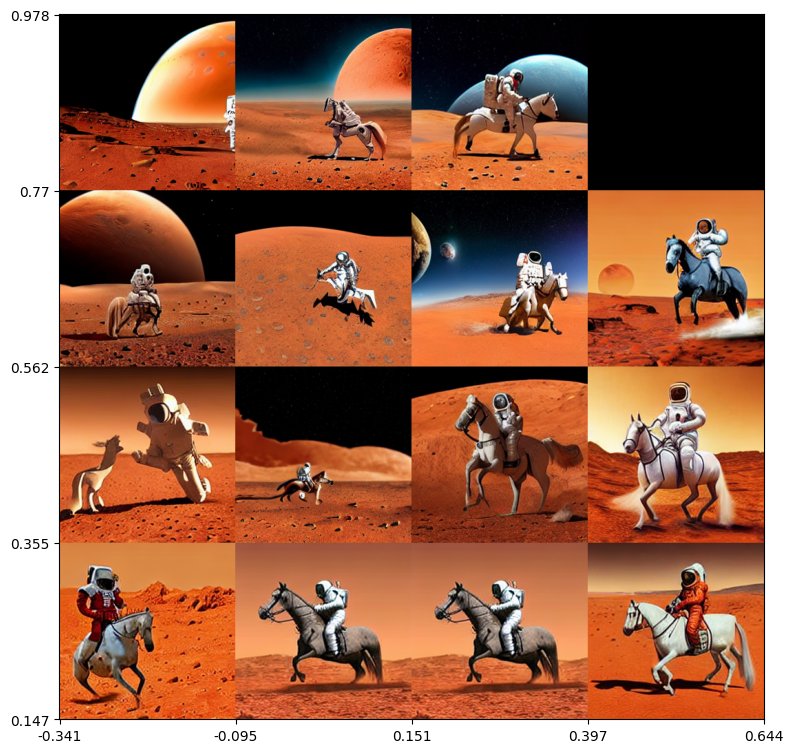

In [15]:
from torchvision.utils import make_grid


def create_archive_tick_labels(measure_range, num_ticks):
    delta = (measure_range[1] - measure_range[0]) / num_ticks
    ticklabels = [round(delta * p + measure_range[0], 3) for p in range(num_ticks + 1)]
    return ticklabels


plt.figure(figsize=(img_freq[0] * 2, img_freq[0] * 2))
img_grid = make_grid(imgs, nrow=img_freq[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))
plt.imshow(img_grid)

plt.xlabel("")
num_x_ticks = img_freq[0]
x_ticklabels = create_archive_tick_labels(measure_bounds[0], num_x_ticks)
x_tick_range = img_grid.shape[1]
x_ticks = np.arange(0, x_tick_range + 1e-9, step=x_tick_range / num_x_ticks)
plt.xticks(x_ticks, x_ticklabels)

plt.ylabel("")
num_y_ticks = img_freq[1]
y_ticklabels = create_archive_tick_labels(measure_bounds[1], num_y_ticks)
y_ticklabels.reverse()
y_tick_range = img_grid.shape[0]
y_ticks = np.arange(0, y_tick_range + 1e-9, step=y_tick_range / num_y_ticks)
plt.yticks(y_ticks, y_ticklabels)

plt.tight_layout()

We can see that QDHF generates a diverse collection of images with some visible trends of diversity such as object size (smaller on upper left, larger on bottom right), scene layout (dark sky on the top, dusty sky on the bottom), etc.


*This tutorial uses light-weight models and smaller batch sizes for faster inference. You should get better results using the [official implementation of QDHF](https://github.com/ld-ing/qdhf).*

## Conclusion

In this tutorial, we explored using the QDHF algorithm to generate diverse images given the text prompt. We showed how QDHF can be implemented using pyribs, and how we use it in a pipeline with Stable Diffusion. The generated images show variations and visible trends of diversity without the need to manually specify diversity metrics.


## Citation

If you find this tutorial useful, please cite our paper:

```text
@article{ding2023quality,
  title={Quality Diversity through Human Feedback},
  author={Ding, Li and Zhang, Jenny and Clune, Jeff and Spector, Lee and Lehman, Joel},
  journal={arXiv preprint arXiv:2310.12103},
  year={2023}
}
```